In [1]:
# Validation of the steady-state simulation - Case 1: MLP
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [2]:
### Defining parameters and hyperparameters of the model

n_units=128 # Number of units in the hidden layer of the MLP network
input_size = 100 + 3 # Size of input for the network (100 coefficients and 3 other parameters, AoA, h, beta)
lr = 1e-03 # Learning rate of the network
test_rate=0.1 # Defines the ratio of training dataset and test dataset
val_rate=0.2
n_data = 16 # Number of txt files from which the aerodynamic coefficients are extracted
batch_size = 20 # Mini-batch size

In [3]:
# Changing working directory

main_directory = 'D:\\VAWT_data\\flap_steady\\flap_steady'
os.chdir(main_directory)

In [4]:
## Basic parameters

c = 1 # Chord length
h = np.array([0.01, 0.02, 0.03]) * c # Height of the Gurney flaps
t = 0.02 * h # Thickness of the Gurney flaps
alpha = np.linspace(0, 16, 9).reshape((9,1)) # Angles of attack
beta = np.linspace(30, 90, 5).reshape((5,1))

In [5]:
h = h.reshape((-1,1))
t = t.reshape((-1,1))

In [6]:
n_alpha = alpha.shape[0] # Number of the angles of attack
n_beta = beta.shape[0] # Number of the Gurney flap inclination
n_h = h.shape[0] # Number of the height of the Gurney flaps
n_cases = n_data * n_alpha # Total number of cases(Number of geometries * Number of angles of attack)

In [7]:
## Creating Input dataset
# Defining the angles of attack

aa = np.zeros((n_cases,1))
for i in range(0, n_data):
    aa[n_alpha*i:n_alpha*(i+1),:] = alpha[:,:]

In [8]:
aa = aa / np.max(alpha)

In [9]:
aa.shape

(144, 1)

In [10]:
# Defining beta, the Gurney flap inclination
# In case of mere NACA0018, the bb in those indexes are considered as zero.
beta_0 = np.zeros((n_alpha,1)) # Values for sheer NACA0018
b_ = np.ones((n_alpha,1)) # Template for the inclination for a single h and single beta
bb_imp = np.zeros((n_alpha*n_beta,1))

for j in range(n_beta):
    b_imp = b_ * beta[j]
    bb_imp[n_alpha*j:n_alpha*(j+1),:] = b_imp[:,:]
    
bb_imp = bb_imp.reshape((-1,1))

bb = np.vstack((beta_0, bb_imp, bb_imp, bb_imp))
bb = bb / np.max(beta)
    
print(bb.shape)

(144, 1)


In [11]:
# Defining the Gurney flap height
# In case of mere NACA0018, the hh in those indexes are considered as zero.

hh = np.concatenate((np.zeros(n_alpha), h[0]*np.ones(n_beta*n_alpha), h[1]*np.ones(n_beta*n_alpha), h[2]*np.ones(n_beta*n_alpha)))
hh = hh.reshape((-1,1))

In [12]:
hh = hh / np.max(h)

In [13]:
# Importing the coordinates of NACA0018 (airfoil15)
origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out\\airfoil15"

csv_file_name = origin_coord + '\\airfoilOut15.txt'
data = pd.read_csv(csv_file_name, header=None)

In [14]:
baseline_coord = data.iloc[:,:].values

In [15]:
standard_coord = baseline_coord.reshape((1, -1))

In [16]:
airfoil_coord = np.repeat(standard_coord, n_cases, axis=0)
print(airfoil_coord.shape)

(144, 100)


In [17]:
# The rows mean the number of points at the Gurney flap
# and the columns mean the number of the cases
flap_left = np.zeros((15,5))
flap_right = np.zeros((15,5))

for i in range(n_h):
    # Defining coordinates of the flaps with respect to beta=90 degree.
    yLeft = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
    yRight = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
    xLeft = 0.5*np.ones((5,1)) - 0.02*h[i]
    xRight = 0.5*np.ones((5,1))
    
    for j in range(n_beta):
        betaValue = beta[j]
        
        # Rotating transformation
        rotateTransf = np.array([[np.cos(90-betaValue), -np.sin(90-betaValue)],
                                 [np.sin(90-betaValue), np.cos(90-betaValue)]])
        rotateTransf = rotateTransf.reshape((2,2))
        
        LeftImp = np.hstack((xLeft-0.5, yLeft))
        RightImp = np.hstack((xRight-0.5, yRight))
        
        rotatedFlapLeft = rotateTransf @ LeftImp.T # shape: 2*5 (x-coordinates on first row, y-coordinates on second row)
        rotatedFlapRight = rotateTransf @ RightImp.T
        
        # All we need is the y-coordinates of the flaps
        flap_left[5*i+j,:] = rotatedFlapLeft[1,:]
        flap_right[5*i+j,:] = rotatedFlapRight[1,:]

In [18]:
# Combining y-coordinates from the left and the right side of the flaps
flap_coords = np.hstack((flap_left, np.flip(flap_right, axis=1)))
print(flap_coords.shape)

(15, 10)


In [19]:
# Placing the flap_coords into total coordinate variable
# Total coordinate = Airfoil coordinates + flap coordinates
flap_coords2 = np.zeros((n_cases, 10))
for i in range(n_alpha, n_cases):
    flap_coords2[i,:] = flap_coords[i%15,:]
    
print(flap_coords2.shape)

(144, 10)


In [20]:
total_coords = np.hstack((airfoil_coord, flap_coords2))
print(total_coords.shape)

(144, 110)


In [21]:
x = np.hstack((aa, hh, bb, total_coords))

In [22]:
## Creating output dataset - Cl and Cd
files_orig = os.listdir(main_directory)
files_target = [file for file in files_orig if file.endswith('.txt')]

In [23]:
target_df = pd.DataFrame()
for file in files_target:
    data = pd.read_table(file, header=None)
    target_df = pd.concat([target_df, data], axis=0)

In [24]:
target_c3 = target_df.iloc[:,3].values # Cd values
target_c4 = target_df.iloc[:,4].values# Cl values

In [25]:
y = np.hstack((target_c3.reshape((-1,1)), target_c4.reshape((-1,1))))

In [26]:
y.shape

(144, 2)

In [27]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_rate, random_state=1)

In [28]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_rate/(1-test_rate), random_state=1)

In [29]:
x_train.shape

(100, 113)

In [30]:
y_train.shape

(100, 2)

In [31]:
tf.keras.backend.set_image_data_format('channels_last')

In [32]:
input_data = tf.keras.Input(shape=(3+total_coords.shape[1]))

x_fc1 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc1')(input_data)
x_fc2 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc2')(x_fc1)
x_fc3 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc3')(x_fc2)
x_fc4 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc4')(x_fc3)
x_fc5 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc5')(x_fc4)

output_data = tf.keras.layers.Dense(units=2, activation='linear', name='outputLayer')(x_fc5)
# MLP(FC layer)-based
model = tf.keras.Model(input_data, output_data)

In [33]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 113)]             0         
                                                                 
 fc1 (Dense)                 (None, 128)               14592     
                                                                 
 fc2 (Dense)                 (None, 128)               16512     
                                                                 
 fc3 (Dense)                 (None, 128)               16512     
                                                                 
 fc4 (Dense)                 (None, 128)               16512     
                                                                 
 fc5 (Dense)                 (None, 128)               16512     
                                                                 
 outputLayer (Dense)         (None, 2)                 258   

In [34]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [35]:
es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1000, min_delta=6e-7,
                                      restore_best_weights=True, verbose=1)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=500, factor=0.5,
                                          min_delta = 1e-07, min_lr=1e-06,
                                          verbose=1)

In [36]:
STEP_SIZE_TRAIN = len(x_train)//batch_size

In [37]:
start = datetime.datetime.now()
history = model.fit(x_train, y_train, validation_data=[x_val, y_val], batch_size=batch_size,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    epochs=5000, shuffle=True, callbacks=[es, rp])
end = datetime.datetime.now()

Epoch 1/5000
5/5 [==============================] - 5s 97ms/step - loss: 0.4352 - rmse: 0.6597 - val_loss: 0.1254 - val_rmse: 0.3541 - lr: 0.0010
Epoch 2/5000
5/5 [==============================] - 0s 15ms/step - loss: 0.1362 - rmse: 0.3690 - val_loss: 0.0912 - val_rmse: 0.3020 - lr: 0.0010
Epoch 3/5000
5/5 [==============================] - 0s 14ms/step - loss: 0.0743 - rmse: 0.2725 - val_loss: 0.0878 - val_rmse: 0.2964 - lr: 0.0010
Epoch 4/5000
5/5 [==============================] - 0s 12ms/step - loss: 0.0737 - rmse: 0.2715 - val_loss: 0.0442 - val_rmse: 0.2102 - lr: 0.0010
Epoch 5/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.0407 - rmse: 0.2017 - val_loss: 0.0338 - val_rmse: 0.1839 - lr: 0.0010
Epoch 6/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.0289 - rmse: 0.1700 - val_loss: 0.0324 - val_rmse: 0.1799 - lr: 0.0010
Epoch 7/5000
5/5 [==============================] - 0s 21ms/step - loss: 0.0245 - rmse: 0.1566 - val_loss: 0.0168 - val_rmse

Epoch 57/5000
5/5 [==============================] - 0s 11ms/step - loss: 0.0056 - rmse: 0.0747 - val_loss: 0.0052 - val_rmse: 0.0724 - lr: 0.0010
Epoch 58/5000
5/5 [==============================] - 0s 12ms/step - loss: 0.0071 - rmse: 0.0844 - val_loss: 0.0136 - val_rmse: 0.1167 - lr: 0.0010
Epoch 59/5000
5/5 [==============================] - 0s 12ms/step - loss: 0.0063 - rmse: 0.0794 - val_loss: 0.0087 - val_rmse: 0.0931 - lr: 0.0010
Epoch 60/5000
5/5 [==============================] - 0s 12ms/step - loss: 0.0053 - rmse: 0.0727 - val_loss: 0.0052 - val_rmse: 0.0720 - lr: 0.0010
Epoch 61/5000
5/5 [==============================] - 0s 12ms/step - loss: 0.0043 - rmse: 0.0655 - val_loss: 0.0032 - val_rmse: 0.0562 - lr: 0.0010
Epoch 62/5000
5/5 [==============================] - 0s 12ms/step - loss: 0.0028 - rmse: 0.0532 - val_loss: 0.0031 - val_rmse: 0.0556 - lr: 0.0010
Epoch 63/5000
5/5 [==============================] - 0s 13ms/step - loss: 0.0025 - rmse: 0.0499 - val_loss: 0.0029 - v

Epoch 112/5000
5/5 [==============================] - 0s 12ms/step - loss: 2.1208e-04 - rmse: 0.0146 - val_loss: 6.5389e-04 - val_rmse: 0.0256 - lr: 0.0010
Epoch 113/5000
5/5 [==============================] - 0s 12ms/step - loss: 2.4030e-04 - rmse: 0.0155 - val_loss: 6.7024e-04 - val_rmse: 0.0259 - lr: 0.0010
Epoch 114/5000
5/5 [==============================] - 0s 12ms/step - loss: 2.5351e-04 - rmse: 0.0159 - val_loss: 6.0293e-04 - val_rmse: 0.0246 - lr: 0.0010
Epoch 115/5000
5/5 [==============================] - 0s 12ms/step - loss: 2.2046e-04 - rmse: 0.0148 - val_loss: 6.9067e-04 - val_rmse: 0.0263 - lr: 0.0010
Epoch 116/5000
5/5 [==============================] - 0s 12ms/step - loss: 2.2555e-04 - rmse: 0.0150 - val_loss: 6.4085e-04 - val_rmse: 0.0253 - lr: 0.0010
Epoch 117/5000
5/5 [==============================] - 0s 12ms/step - loss: 1.5807e-04 - rmse: 0.0126 - val_loss: 6.7337e-04 - val_rmse: 0.0259 - lr: 0.0010
Epoch 118/5000
5/5 [==============================] - 0s 12ms/st

Epoch 218/5000
5/5 [==============================] - 0s 12ms/step - loss: 2.8923e-05 - rmse: 0.0054 - val_loss: 3.2209e-04 - val_rmse: 0.0179 - lr: 0.0010
Epoch 219/5000
5/5 [==============================] - 0s 12ms/step - loss: 5.5183e-05 - rmse: 0.0074 - val_loss: 3.9706e-04 - val_rmse: 0.0199 - lr: 0.0010
Epoch 220/5000
5/5 [==============================] - 0s 11ms/step - loss: 4.2736e-05 - rmse: 0.0065 - val_loss: 3.0219e-04 - val_rmse: 0.0174 - lr: 0.0010
Epoch 221/5000
5/5 [==============================] - 0s 12ms/step - loss: 2.6422e-05 - rmse: 0.0051 - val_loss: 3.3903e-04 - val_rmse: 0.0184 - lr: 0.0010
Epoch 222/5000
5/5 [==============================] - 0s 12ms/step - loss: 2.6605e-05 - rmse: 0.0052 - val_loss: 2.9841e-04 - val_rmse: 0.0173 - lr: 0.0010
Epoch 223/5000
5/5 [==============================] - 0s 12ms/step - loss: 2.9772e-05 - rmse: 0.0055 - val_loss: 2.9771e-04 - val_rmse: 0.0173 - lr: 0.0010
Epoch 224/5000
5/5 [==============================] - 0s 12ms/st

Epoch 324/5000
5/5 [==============================] - 0s 12ms/step - loss: 2.3992e-04 - rmse: 0.0155 - val_loss: 7.9638e-04 - val_rmse: 0.0282 - lr: 0.0010
Epoch 325/5000
5/5 [==============================] - 0s 12ms/step - loss: 2.0293e-04 - rmse: 0.0142 - val_loss: 6.9203e-04 - val_rmse: 0.0263 - lr: 0.0010
Epoch 326/5000
5/5 [==============================] - 0s 12ms/step - loss: 2.0623e-04 - rmse: 0.0144 - val_loss: 6.0426e-04 - val_rmse: 0.0246 - lr: 0.0010
Epoch 327/5000
5/5 [==============================] - 0s 12ms/step - loss: 1.4058e-04 - rmse: 0.0119 - val_loss: 5.7274e-04 - val_rmse: 0.0239 - lr: 0.0010
Epoch 328/5000
5/5 [==============================] - 0s 12ms/step - loss: 1.4573e-04 - rmse: 0.0121 - val_loss: 7.0926e-04 - val_rmse: 0.0266 - lr: 0.0010
Epoch 329/5000
5/5 [==============================] - 0s 12ms/step - loss: 1.1053e-04 - rmse: 0.0105 - val_loss: 8.3402e-04 - val_rmse: 0.0289 - lr: 0.0010
Epoch 330/5000
5/5 [==============================] - 0s 12ms/st

Epoch 429/5000
5/5 [==============================] - 0s 12ms/step - loss: 1.5018e-05 - rmse: 0.0039 - val_loss: 4.0194e-04 - val_rmse: 0.0200 - lr: 0.0010
Epoch 430/5000
5/5 [==============================] - 0s 12ms/step - loss: 2.4659e-05 - rmse: 0.0050 - val_loss: 4.6977e-04 - val_rmse: 0.0217 - lr: 0.0010
Epoch 431/5000
5/5 [==============================] - 0s 12ms/step - loss: 2.9332e-05 - rmse: 0.0054 - val_loss: 4.6660e-04 - val_rmse: 0.0216 - lr: 0.0010
Epoch 432/5000
5/5 [==============================] - 0s 11ms/step - loss: 2.3015e-05 - rmse: 0.0048 - val_loss: 4.4664e-04 - val_rmse: 0.0211 - lr: 0.0010
Epoch 433/5000
5/5 [==============================] - 0s 12ms/step - loss: 1.7731e-05 - rmse: 0.0042 - val_loss: 4.1835e-04 - val_rmse: 0.0205 - lr: 0.0010
Epoch 434/5000
5/5 [==============================] - 0s 12ms/step - loss: 1.4974e-05 - rmse: 0.0039 - val_loss: 3.9195e-04 - val_rmse: 0.0198 - lr: 0.0010
Epoch 435/5000
5/5 [==============================] - 0s 12ms/st

Epoch 534/5000
5/5 [==============================] - 0s 12ms/step - loss: 7.0528e-05 - rmse: 0.0084 - val_loss: 5.9770e-04 - val_rmse: 0.0244 - lr: 0.0010
Epoch 535/5000
5/5 [==============================] - 0s 12ms/step - loss: 6.6053e-05 - rmse: 0.0081 - val_loss: 4.3769e-04 - val_rmse: 0.0209 - lr: 0.0010
Epoch 536/5000
5/5 [==============================] - 0s 12ms/step - loss: 6.1956e-05 - rmse: 0.0079 - val_loss: 3.2211e-04 - val_rmse: 0.0179 - lr: 0.0010
Epoch 537/5000
5/5 [==============================] - 0s 12ms/step - loss: 6.8635e-05 - rmse: 0.0083 - val_loss: 6.2301e-04 - val_rmse: 0.0250 - lr: 0.0010
Epoch 538/5000
5/5 [==============================] - 0s 11ms/step - loss: 9.6726e-05 - rmse: 0.0098 - val_loss: 3.9721e-04 - val_rmse: 0.0199 - lr: 0.0010
Epoch 539/5000
5/5 [==============================] - 0s 12ms/step - loss: 9.8692e-05 - rmse: 0.0099 - val_loss: 5.5285e-04 - val_rmse: 0.0235 - lr: 0.0010
Epoch 540/5000
5/5 [==============================] - 0s 12ms/st

Epoch 640/5000
5/5 [==============================] - 0s 12ms/step - loss: 2.0433e-04 - rmse: 0.0143 - val_loss: 6.0743e-04 - val_rmse: 0.0246 - lr: 0.0010
Epoch 641/5000
5/5 [==============================] - 0s 12ms/step - loss: 2.4746e-04 - rmse: 0.0157 - val_loss: 8.0491e-04 - val_rmse: 0.0284 - lr: 0.0010
Epoch 642/5000
5/5 [==============================] - 0s 12ms/step - loss: 6.2215e-04 - rmse: 0.0249 - val_loss: 0.0013 - val_rmse: 0.0363 - lr: 0.0010
Epoch 643/5000
5/5 [==============================] - 0s 12ms/step - loss: 6.9272e-04 - rmse: 0.0263 - val_loss: 0.0014 - val_rmse: 0.0370 - lr: 0.0010
Epoch 644/5000
5/5 [==============================] - 0s 12ms/step - loss: 0.0012 - rmse: 0.0350 - val_loss: 0.0035 - val_rmse: 0.0589 - lr: 0.0010
Epoch 645/5000
5/5 [==============================] - 0s 12ms/step - loss: 0.0015 - rmse: 0.0382 - val_loss: 0.0040 - val_rmse: 0.0634 - lr: 0.0010
Epoch 646/5000
5/5 [==============================] - 0s 12ms/step - loss: 0.0022 - rmse

Epoch 694/5000
5/5 [==============================] - 0s 12ms/step - loss: 6.0222e-05 - rmse: 0.0078 - val_loss: 3.0473e-04 - val_rmse: 0.0175 - lr: 0.0010
Epoch 695/5000
5/5 [==============================] - 0s 12ms/step - loss: 3.5892e-05 - rmse: 0.0060 - val_loss: 2.8297e-04 - val_rmse: 0.0168 - lr: 0.0010
Epoch 696/5000
5/5 [==============================] - 0s 11ms/step - loss: 3.1801e-05 - rmse: 0.0056 - val_loss: 2.7874e-04 - val_rmse: 0.0167 - lr: 0.0010
Epoch 697/5000
5/5 [==============================] - 0s 12ms/step - loss: 2.4329e-05 - rmse: 0.0049 - val_loss: 2.9577e-04 - val_rmse: 0.0172 - lr: 0.0010
Epoch 698/5000
5/5 [==============================] - 0s 12ms/step - loss: 2.5494e-05 - rmse: 0.0050 - val_loss: 2.7439e-04 - val_rmse: 0.0166 - lr: 0.0010
Epoch 699/5000
5/5 [==============================] - 0s 12ms/step - loss: 3.2750e-05 - rmse: 0.0057 - val_loss: 2.9934e-04 - val_rmse: 0.0173 - lr: 0.0010
Epoch 700/5000
5/5 [==============================] - 0s 12ms/st

Epoch 799/5000
5/5 [==============================] - 0s 12ms/step - loss: 3.5918e-06 - rmse: 0.0019 - val_loss: 2.1247e-04 - val_rmse: 0.0146 - lr: 0.0010
Epoch 800/5000
5/5 [==============================] - 0s 12ms/step - loss: 5.7239e-06 - rmse: 0.0024 - val_loss: 2.0828e-04 - val_rmse: 0.0144 - lr: 0.0010
Epoch 801/5000
5/5 [==============================] - 0s 12ms/step - loss: 4.3952e-06 - rmse: 0.0021 - val_loss: 2.1800e-04 - val_rmse: 0.0148 - lr: 0.0010
Epoch 802/5000
5/5 [==============================] - 0s 12ms/step - loss: 5.7361e-06 - rmse: 0.0024 - val_loss: 2.0585e-04 - val_rmse: 0.0143 - lr: 0.0010
Epoch 803/5000
5/5 [==============================] - 0s 12ms/step - loss: 6.5070e-06 - rmse: 0.0026 - val_loss: 2.1356e-04 - val_rmse: 0.0146 - lr: 0.0010
Epoch 804/5000
5/5 [==============================] - 0s 12ms/step - loss: 6.4819e-06 - rmse: 0.0025 - val_loss: 2.1570e-04 - val_rmse: 0.0147 - lr: 0.0010
Epoch 805/5000
5/5 [==============================] - 0s 11ms/st

5/5 [==============================] - 0s 12ms/step - loss: 2.1740e-06 - rmse: 0.0015 - val_loss: 1.9540e-04 - val_rmse: 0.0140 - lr: 0.0010
Epoch 904/5000
5/5 [==============================] - 0s 12ms/step - loss: 1.6814e-06 - rmse: 0.0013 - val_loss: 1.9360e-04 - val_rmse: 0.0139 - lr: 0.0010
Epoch 905/5000
5/5 [==============================] - 0s 12ms/step - loss: 1.8328e-06 - rmse: 0.0014 - val_loss: 1.9613e-04 - val_rmse: 0.0140 - lr: 0.0010
Epoch 906/5000
5/5 [==============================] - 0s 12ms/step - loss: 1.7262e-06 - rmse: 0.0013 - val_loss: 1.9797e-04 - val_rmse: 0.0141 - lr: 0.0010
Epoch 907/5000
5/5 [==============================] - 0s 12ms/step - loss: 1.8352e-06 - rmse: 0.0014 - val_loss: 1.9865e-04 - val_rmse: 0.0141 - lr: 0.0010
Epoch 908/5000
5/5 [==============================] - 0s 11ms/step - loss: 1.7278e-06 - rmse: 0.0013 - val_loss: 1.9548e-04 - val_rmse: 0.0140 - lr: 0.0010
Epoch 909/5000
5/5 [==============================] - 0s 12ms/step - loss: 1.27

5/5 [==============================] - 0s 11ms/step - loss: 1.1746e-06 - rmse: 0.0011 - val_loss: 1.9671e-04 - val_rmse: 0.0140 - lr: 0.0010
Epoch 1008/5000
5/5 [==============================] - 0s 12ms/step - loss: 1.2146e-06 - rmse: 0.0011 - val_loss: 1.8780e-04 - val_rmse: 0.0137 - lr: 0.0010
Epoch 1009/5000
5/5 [==============================] - 0s 12ms/step - loss: 7.6035e-07 - rmse: 8.7198e-04 - val_loss: 1.7990e-04 - val_rmse: 0.0134 - lr: 0.0010
Epoch 1010/5000
5/5 [==============================] - 0s 12ms/step - loss: 9.8159e-07 - rmse: 9.9075e-04 - val_loss: 1.9565e-04 - val_rmse: 0.0140 - lr: 0.0010
Epoch 1011/5000
5/5 [==============================] - 0s 11ms/step - loss: 1.3523e-06 - rmse: 0.0012 - val_loss: 1.7711e-04 - val_rmse: 0.0133 - lr: 0.0010
Epoch 1012/5000
5/5 [==============================] - 0s 12ms/step - loss: 1.2356e-06 - rmse: 0.0011 - val_loss: 1.9884e-04 - val_rmse: 0.0141 - lr: 0.0010
Epoch 1013/5000
5/5 [==============================] - 0s 12ms/ste

Epoch 1112/5000
5/5 [==============================] - 0s 12ms/step - loss: 1.7312e-04 - rmse: 0.0132 - val_loss: 5.2311e-04 - val_rmse: 0.0229 - lr: 0.0010
Epoch 1113/5000
5/5 [==============================] - 0s 11ms/step - loss: 1.1686e-04 - rmse: 0.0108 - val_loss: 4.1552e-04 - val_rmse: 0.0204 - lr: 0.0010
Epoch 1114/5000
5/5 [==============================] - 0s 12ms/step - loss: 1.2584e-04 - rmse: 0.0112 - val_loss: 4.4814e-04 - val_rmse: 0.0212 - lr: 0.0010
Epoch 1115/5000
5/5 [==============================] - 0s 12ms/step - loss: 1.0466e-04 - rmse: 0.0102 - val_loss: 3.4719e-04 - val_rmse: 0.0186 - lr: 0.0010
Epoch 1116/5000
5/5 [==============================] - 0s 12ms/step - loss: 7.5097e-05 - rmse: 0.0087 - val_loss: 4.3880e-04 - val_rmse: 0.0209 - lr: 0.0010
Epoch 1117/5000
5/5 [==============================] - 0s 12ms/step - loss: 9.2284e-05 - rmse: 0.0096 - val_loss: 3.3438e-04 - val_rmse: 0.0183 - lr: 0.0010
Epoch 1118/5000
5/5 [==============================] - 0s 

5/5 [==============================] - 0s 12ms/step - loss: 6.3261e-06 - rmse: 0.0025 - val_loss: 2.4224e-04 - val_rmse: 0.0156 - lr: 0.0010
Epoch 1217/5000
5/5 [==============================] - 0s 13ms/step - loss: 7.1566e-06 - rmse: 0.0027 - val_loss: 2.5205e-04 - val_rmse: 0.0159 - lr: 0.0010
Epoch 1218/5000
5/5 [==============================] - 0s 12ms/step - loss: 6.2773e-06 - rmse: 0.0025 - val_loss: 2.5685e-04 - val_rmse: 0.0160 - lr: 0.0010
Epoch 1219/5000
5/5 [==============================] - 0s 12ms/step - loss: 6.2450e-06 - rmse: 0.0025 - val_loss: 2.5353e-04 - val_rmse: 0.0159 - lr: 0.0010
Epoch 1220/5000
5/5 [==============================] - 0s 12ms/step - loss: 5.0149e-06 - rmse: 0.0022 - val_loss: 2.3742e-04 - val_rmse: 0.0154 - lr: 0.0010
Epoch 1221/5000
5/5 [==============================] - 0s 13ms/step - loss: 4.9928e-06 - rmse: 0.0022 - val_loss: 2.4426e-04 - val_rmse: 0.0156 - lr: 0.0010
Epoch 1222/5000
5/5 [==============================] - 0s 13ms/step - loss

5/5 [==============================] - 0s 13ms/step - loss: 1.6092e-06 - rmse: 0.0013 - val_loss: 2.1346e-04 - val_rmse: 0.0146 - lr: 0.0010
Epoch 1321/5000
5/5 [==============================] - 0s 14ms/step - loss: 1.9356e-06 - rmse: 0.0014 - val_loss: 2.1073e-04 - val_rmse: 0.0145 - lr: 0.0010
Epoch 1322/5000
5/5 [==============================] - 0s 12ms/step - loss: 2.2771e-06 - rmse: 0.0015 - val_loss: 2.1283e-04 - val_rmse: 0.0146 - lr: 0.0010
Epoch 1323/5000
5/5 [==============================] - 0s 12ms/step - loss: 1.6315e-06 - rmse: 0.0013 - val_loss: 2.0398e-04 - val_rmse: 0.0143 - lr: 0.0010
Epoch 1324/5000
5/5 [==============================] - 0s 13ms/step - loss: 1.5358e-06 - rmse: 0.0012 - val_loss: 2.1285e-04 - val_rmse: 0.0146 - lr: 0.0010
Epoch 1325/5000
5/5 [==============================] - 0s 12ms/step - loss: 2.4195e-06 - rmse: 0.0016 - val_loss: 2.0751e-04 - val_rmse: 0.0144 - lr: 0.0010
Epoch 1326/5000
5/5 [==============================] - 0s 12ms/step - loss

5/5 [==============================] - 0s 13ms/step - loss: 1.4101e-06 - rmse: 0.0012 - val_loss: 1.9027e-04 - val_rmse: 0.0138 - lr: 0.0010
Epoch 1425/5000
5/5 [==============================] - 0s 13ms/step - loss: 2.0040e-06 - rmse: 0.0014 - val_loss: 2.0217e-04 - val_rmse: 0.0142 - lr: 0.0010
Epoch 1426/5000
5/5 [==============================] - 0s 12ms/step - loss: 2.7681e-06 - rmse: 0.0017 - val_loss: 2.1292e-04 - val_rmse: 0.0146 - lr: 0.0010
Epoch 1427/5000
5/5 [==============================] - 0s 13ms/step - loss: 3.2658e-06 - rmse: 0.0018 - val_loss: 2.0623e-04 - val_rmse: 0.0144 - lr: 0.0010
Epoch 1428/5000
5/5 [==============================] - 0s 12ms/step - loss: 4.7077e-06 - rmse: 0.0022 - val_loss: 2.1040e-04 - val_rmse: 0.0145 - lr: 0.0010
Epoch 1429/5000
5/5 [==============================] - 0s 12ms/step - loss: 6.5144e-06 - rmse: 0.0026 - val_loss: 2.1476e-04 - val_rmse: 0.0147 - lr: 0.0010
Epoch 1430/5000
5/5 [==============================] - 0s 12ms/step - loss

5/5 [==============================] - 0s 13ms/step - loss: 3.5086e-06 - rmse: 0.0019 - val_loss: 2.1133e-04 - val_rmse: 0.0145 - lr: 0.0010
Epoch 1529/5000
5/5 [==============================] - 0s 12ms/step - loss: 2.5342e-06 - rmse: 0.0016 - val_loss: 2.1472e-04 - val_rmse: 0.0147 - lr: 0.0010
Epoch 1530/5000
1/5 [=====>........................] - ETA: 0s - loss: 4.0959e-06 - rmse: 0.0020
Epoch 1530: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
5/5 [==============================] - 0s 12ms/step - loss: 3.7852e-06 - rmse: 0.0019 - val_loss: 2.1869e-04 - val_rmse: 0.0148 - lr: 0.0010
Epoch 1531/5000
5/5 [==============================] - 0s 12ms/step - loss: 2.3802e-06 - rmse: 0.0015 - val_loss: 2.1626e-04 - val_rmse: 0.0147 - lr: 5.0000e-04
Epoch 1532/5000
5/5 [==============================] - 0s 11ms/step - loss: 2.2377e-06 - rmse: 0.0015 - val_loss: 2.0860e-04 - val_rmse: 0.0144 - lr: 5.0000e-04
Epoch 1533/5000
5/5 [==============================] - 0s 12ms/

Epoch 1627/5000
5/5 [==============================] - 0s 12ms/step - loss: 2.5649e-07 - rmse: 5.0645e-04 - val_loss: 2.0373e-04 - val_rmse: 0.0143 - lr: 5.0000e-04
Epoch 1628/5000
5/5 [==============================] - 0s 12ms/step - loss: 3.0652e-07 - rmse: 5.5364e-04 - val_loss: 2.0256e-04 - val_rmse: 0.0142 - lr: 5.0000e-04
Epoch 1629/5000
5/5 [==============================] - 0s 12ms/step - loss: 2.9186e-07 - rmse: 5.4024e-04 - val_loss: 2.0333e-04 - val_rmse: 0.0143 - lr: 5.0000e-04
Epoch 1630/5000
5/5 [==============================] - 0s 12ms/step - loss: 2.7571e-07 - rmse: 5.2508e-04 - val_loss: 2.0059e-04 - val_rmse: 0.0142 - lr: 5.0000e-04
Epoch 1631/5000
5/5 [==============================] - 0s 11ms/step - loss: 3.4465e-07 - rmse: 5.8707e-04 - val_loss: 2.0300e-04 - val_rmse: 0.0142 - lr: 5.0000e-04
Epoch 1632/5000
5/5 [==============================] - 0s 12ms/step - loss: 2.6578e-07 - rmse: 5.1554e-04 - val_loss: 2.0196e-04 - val_rmse: 0.0142 - lr: 5.0000e-04
Epoch 1633

Epoch 1677/5000
5/5 [==============================] - 0s 16ms/step - loss: 4.8845e-07 - rmse: 6.9889e-04 - val_loss: 1.9850e-04 - val_rmse: 0.0141 - lr: 5.0000e-04
Epoch 1678/5000
5/5 [==============================] - 0s 16ms/step - loss: 4.5080e-07 - rmse: 6.7141e-04 - val_loss: 1.9948e-04 - val_rmse: 0.0141 - lr: 5.0000e-04
Epoch 1679/5000
5/5 [==============================] - 0s 15ms/step - loss: 5.1573e-07 - rmse: 7.1815e-04 - val_loss: 2.0120e-04 - val_rmse: 0.0142 - lr: 5.0000e-04
Epoch 1680/5000
5/5 [==============================] - 0s 14ms/step - loss: 4.5583e-07 - rmse: 6.7515e-04 - val_loss: 2.0388e-04 - val_rmse: 0.0143 - lr: 5.0000e-04
Epoch 1681/5000
5/5 [==============================] - 0s 14ms/step - loss: 3.6143e-07 - rmse: 6.0119e-04 - val_loss: 2.0353e-04 - val_rmse: 0.0143 - lr: 5.0000e-04
Epoch 1682/5000
5/5 [==============================] - 0s 14ms/step - loss: 4.4175e-07 - rmse: 6.6464e-04 - val_loss: 2.0327e-04 - val_rmse: 0.0143 - lr: 5.0000e-04
Epoch 1683

Epoch 1727/5000
5/5 [==============================] - 0s 12ms/step - loss: 8.4940e-07 - rmse: 9.2163e-04 - val_loss: 1.9795e-04 - val_rmse: 0.0141 - lr: 5.0000e-04
Epoch 1728/5000
5/5 [==============================] - 0s 13ms/step - loss: 6.1959e-07 - rmse: 7.8714e-04 - val_loss: 2.0166e-04 - val_rmse: 0.0142 - lr: 5.0000e-04
Epoch 1729/5000
5/5 [==============================] - 0s 12ms/step - loss: 6.0053e-07 - rmse: 7.7494e-04 - val_loss: 2.0415e-04 - val_rmse: 0.0143 - lr: 5.0000e-04
Epoch 1730/5000
5/5 [==============================] - 0s 12ms/step - loss: 7.5434e-07 - rmse: 8.6853e-04 - val_loss: 1.9847e-04 - val_rmse: 0.0141 - lr: 5.0000e-04
Epoch 1731/5000
5/5 [==============================] - 0s 12ms/step - loss: 8.4833e-07 - rmse: 9.2105e-04 - val_loss: 2.0132e-04 - val_rmse: 0.0142 - lr: 5.0000e-04
Epoch 1732/5000
5/5 [==============================] - 0s 12ms/step - loss: 7.1382e-07 - rmse: 8.4488e-04 - val_loss: 1.8956e-04 - val_rmse: 0.0138 - lr: 5.0000e-04
Epoch 1733

Epoch 1777/5000
5/5 [==============================] - 0s 12ms/step - loss: 2.2978e-06 - rmse: 0.0015 - val_loss: 1.9994e-04 - val_rmse: 0.0141 - lr: 5.0000e-04
Epoch 1778/5000
5/5 [==============================] - 0s 12ms/step - loss: 1.6406e-06 - rmse: 0.0013 - val_loss: 2.1085e-04 - val_rmse: 0.0145 - lr: 5.0000e-04
Epoch 1779/5000
5/5 [==============================] - 0s 12ms/step - loss: 2.6094e-06 - rmse: 0.0016 - val_loss: 1.9922e-04 - val_rmse: 0.0141 - lr: 5.0000e-04
Epoch 1780/5000
5/5 [==============================] - 0s 12ms/step - loss: 2.4813e-06 - rmse: 0.0016 - val_loss: 1.9974e-04 - val_rmse: 0.0141 - lr: 5.0000e-04
Epoch 1781/5000
5/5 [==============================] - 0s 12ms/step - loss: 1.5757e-06 - rmse: 0.0013 - val_loss: 1.9930e-04 - val_rmse: 0.0141 - lr: 5.0000e-04
Epoch 1782/5000
5/5 [==============================] - 0s 12ms/step - loss: 1.5007e-06 - rmse: 0.0012 - val_loss: 2.0323e-04 - val_rmse: 0.0143 - lr: 5.0000e-04
Epoch 1783/5000
5/5 [=============

5/5 [==============================] - 0s 12ms/step - loss: 4.6719e-07 - rmse: 6.8351e-04 - val_loss: 1.9504e-04 - val_rmse: 0.0140 - lr: 5.0000e-04
Epoch 1828/5000
5/5 [==============================] - 0s 12ms/step - loss: 4.6202e-07 - rmse: 6.7972e-04 - val_loss: 1.9702e-04 - val_rmse: 0.0140 - lr: 5.0000e-04
Epoch 1829/5000
5/5 [==============================] - 0s 12ms/step - loss: 3.2235e-07 - rmse: 5.6776e-04 - val_loss: 1.9939e-04 - val_rmse: 0.0141 - lr: 5.0000e-04
Epoch 1830/5000
5/5 [==============================] - 0s 13ms/step - loss: 3.2077e-07 - rmse: 5.6637e-04 - val_loss: 2.0092e-04 - val_rmse: 0.0142 - lr: 5.0000e-04
Epoch 1831/5000
5/5 [==============================] - 0s 12ms/step - loss: 2.8754e-07 - rmse: 5.3623e-04 - val_loss: 2.0077e-04 - val_rmse: 0.0142 - lr: 5.0000e-04
Epoch 1832/5000
5/5 [==============================] - 0s 12ms/step - loss: 3.4501e-07 - rmse: 5.8737e-04 - val_loss: 1.9783e-04 - val_rmse: 0.0141 - lr: 5.0000e-04
Epoch 1833/5000
5/5 [=====

Epoch 1878/5000
5/5 [==============================] - 0s 12ms/step - loss: 3.0098e-05 - rmse: 0.0055 - val_loss: 2.6958e-04 - val_rmse: 0.0164 - lr: 5.0000e-04
Epoch 1879/5000
5/5 [==============================] - 0s 11ms/step - loss: 2.4140e-05 - rmse: 0.0049 - val_loss: 2.4860e-04 - val_rmse: 0.0158 - lr: 5.0000e-04
Epoch 1880/5000
5/5 [==============================] - 0s 11ms/step - loss: 2.6526e-05 - rmse: 0.0052 - val_loss: 2.0099e-04 - val_rmse: 0.0142 - lr: 5.0000e-04
Epoch 1881/5000
5/5 [==============================] - 0s 11ms/step - loss: 1.3850e-05 - rmse: 0.0037 - val_loss: 1.9986e-04 - val_rmse: 0.0141 - lr: 5.0000e-04
Epoch 1882/5000
5/5 [==============================] - 0s 12ms/step - loss: 3.7406e-05 - rmse: 0.0061 - val_loss: 2.5796e-04 - val_rmse: 0.0161 - lr: 5.0000e-04
Epoch 1883/5000
5/5 [==============================] - 0s 12ms/step - loss: 2.1968e-05 - rmse: 0.0047 - val_loss: 1.8419e-04 - val_rmse: 0.0136 - lr: 5.0000e-04
Epoch 1884/5000
5/5 [=============

Epoch 1929/5000
5/5 [==============================] - 0s 12ms/step - loss: 2.1981e-04 - rmse: 0.0148 - val_loss: 3.0191e-04 - val_rmse: 0.0174 - lr: 5.0000e-04
Epoch 1930/5000
5/5 [==============================] - 0s 12ms/step - loss: 3.5763e-04 - rmse: 0.0189 - val_loss: 0.0011 - val_rmse: 0.0328 - lr: 5.0000e-04
Epoch 1931/5000
5/5 [==============================] - 0s 12ms/step - loss: 0.0012 - rmse: 0.0347 - val_loss: 0.0012 - val_rmse: 0.0347 - lr: 5.0000e-04
Epoch 1932/5000
5/5 [==============================] - 0s 12ms/step - loss: 0.0011 - rmse: 0.0336 - val_loss: 0.0015 - val_rmse: 0.0384 - lr: 5.0000e-04
Epoch 1933/5000
5/5 [==============================] - 0s 12ms/step - loss: 0.0012 - rmse: 0.0350 - val_loss: 0.0018 - val_rmse: 0.0427 - lr: 5.0000e-04
Epoch 1934/5000
5/5 [==============================] - 0s 12ms/step - loss: 3.7991e-04 - rmse: 0.0195 - val_loss: 8.3894e-04 - val_rmse: 0.0290 - lr: 5.0000e-04
Epoch 1935/5000
5/5 [==============================] - 0s 12ms

5/5 [==============================] - 0s 12ms/step - loss: 2.4058e-06 - rmse: 0.0016 - val_loss: 2.0764e-04 - val_rmse: 0.0144 - lr: 5.0000e-04
Epoch 1981/5000
5/5 [==============================] - 0s 12ms/step - loss: 2.4173e-06 - rmse: 0.0016 - val_loss: 1.9373e-04 - val_rmse: 0.0139 - lr: 5.0000e-04
Epoch 1982/5000
5/5 [==============================] - 0s 12ms/step - loss: 2.0341e-06 - rmse: 0.0014 - val_loss: 1.9560e-04 - val_rmse: 0.0140 - lr: 5.0000e-04
Epoch 1983/5000
5/5 [==============================] - 0s 12ms/step - loss: 1.9325e-06 - rmse: 0.0014 - val_loss: 1.8990e-04 - val_rmse: 0.0138 - lr: 5.0000e-04
Epoch 1984/5000
5/5 [==============================] - 0s 12ms/step - loss: 2.0587e-06 - rmse: 0.0014 - val_loss: 2.0114e-04 - val_rmse: 0.0142 - lr: 5.0000e-04
Epoch 1985/5000
5/5 [==============================] - 0s 12ms/step - loss: 2.2894e-06 - rmse: 0.0015 - val_loss: 2.0074e-04 - val_rmse: 0.0142 - lr: 5.0000e-04
Epoch 1986/5000
5/5 [=============================

In [38]:
time = end - start
print("Training time:", time)

Training time: 0:02:00.655268


In [39]:
storage_dir = "D:\\VAWT_data\\flap_steady\\flap_steady\\result\\"+"20221120MLP_revised\\val_"+str(val_rate)+'_'+str(test_rate)
if not os.path.exists(storage_dir):
    os.makedirs(storage_dir)
os.chdir(storage_dir)

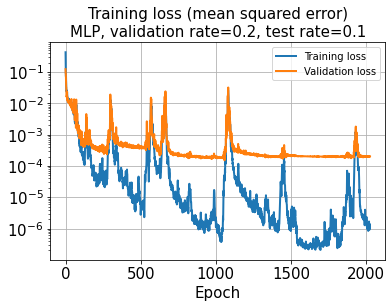

In [40]:
hist = history.history
plt.plot(hist['loss'], lw=2)
plt.plot(hist['val_loss'], lw=2)
plt.title('Training loss (mean squared error)\nMLP, validation rate={0}, test rate={1}'.format(val_rate, test_rate), size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(['Training loss','Validation loss'])
saveName = "TrainingLoss_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

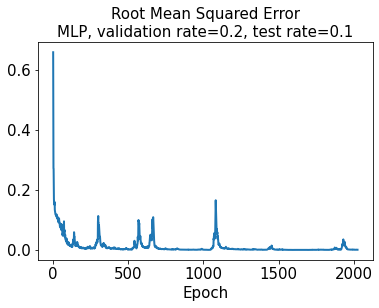

In [41]:
plt.plot(hist['rmse'], lw=2)
plt.title('Root Mean Squared Error\nMLP, validation rate={0}, test rate={1}'.format(val_rate, test_rate), size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

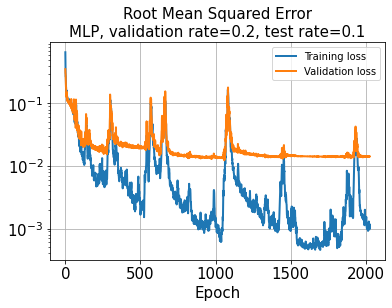

In [42]:
plt.plot(hist['rmse'], lw=2)
plt.plot(hist['val_rmse'], lw=2)
plt.title('Root Mean Squared Error\nMLP, validation rate={0}, test rate={1}'.format(val_rate, test_rate), size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(['Training loss','Validation loss'])
saveName = "RMSE_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [43]:
train_results = model.evaluate(x_train, y_train)

4/4 [==============================] - 0s 4ms/step - loss: 3.6793e-07 - rmse: 6.0657e-04


In [44]:
test_results = model.evaluate(x_test, y_test)

1/1 [==============================] - 0s 21ms/step - loss: 7.1976e-05 - rmse: 0.0085


In [45]:
decoded_train = model.predict(x_train)
decoded_val = model.predict(x_val)
decoded_test = model.predict(x_test)

1/1 [==============================] - 0s 15ms/step


In [46]:
model_directory = "D:\\TrainedModels\\20221128"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
os.chdir(model_directory)
model_name = "20221128steadyValidation_MLP_val"+str(val_rate)+"_test"+str(test_rate)+ "_" + str(n_units) +"units_normalized.h5"
model.save(model_name, overwrite=True, include_optimizer=True, save_format='h5')

In [47]:
error_train_abs = np.abs(decoded_train - y_train)

In [48]:
error_val_abs = np.abs(decoded_val - y_val)

In [49]:
error_test_abs = np.abs(decoded_test - y_test)

In [50]:
os.chdir(storage_dir)

In [51]:
l2_error_train = np.sqrt(np.sum((decoded_train - y_train)**2) / np.sum(y_train**2))
print(l2_error_train)

0.0007159869099268822


In [52]:
l2_error_val = np.sqrt(np.sum((decoded_val - y_val)**2) / np.sum(y_val**2))
print(l2_error_val)

0.015468792708692327


In [53]:
l2_error_test = np.sqrt(np.sum((decoded_test - y_test)**2) / np.sum(y_test**2))
print(l2_error_test)

0.009805286614811429


In [54]:
l2_error_Cd_train = np.sqrt(np.sum((decoded_train[:,0] - y_train[:,0])**2) / np.sum(y_train[:,0]**2))
print(l2_error_Cd_train)

0.014626698502368583


In [55]:
l2_error_Cl_train = np.sqrt(np.sum((decoded_train[:,1] - y_train[:,1])**2) / np.sum(y_train[:,1]**2))
print(l2_error_Cl_train)

0.00045888070484250825


In [56]:
l2_error_Cd_val = np.sqrt(np.sum((decoded_val[:,0] - y_val[:,0])**2) / np.sum(y_val[:,0]**2))
print(l2_error_Cd_val)

0.0641339127733625


In [57]:
l2_error_Cl_val = np.sqrt(np.sum((decoded_val[:,1] - y_val[:,1])**2) / np.sum(y_val[:,1]**2))
print(l2_error_Cl_val)

0.015318444777017088


In [58]:
l2_error_Cd_test = np.sqrt(np.sum((decoded_test[:,0] - y_test[:,0])**2) / np.sum(y_test[:,0]**2))
print(l2_error_Cd_test)

0.04337238804623774


In [59]:
l2_error_Cl_test = np.sqrt(np.sum((decoded_test[:,1] - y_test[:,1])**2) / np.sum(y_test[:,1]**2))
print(l2_error_Cl_test)

0.009713033026197538


In [60]:
l2_error_train_list = []
for i in range(0, len(x_train)):
    l2_error_train_data = np.sqrt(np.sum((decoded_train[i] - y_train[i])**2) / np.sum(y_train[i]**2))
    l2_error_train_list.append(l2_error_train_data)

In [61]:
l2_error_val_list = []
for i in range(0, len(x_val)):
    l2_error_val_data = np.sqrt(np.sum((decoded_val[i] - y_val[i])**2) / np.sum(y_val[i]**2))
    l2_error_val_list.append(l2_error_val_data)

In [62]:
l2_error_test_list = []
for i in range(0, len(x_test)):
    l2_error_test_data = np.sqrt(np.sum((decoded_test[i] - y_test[i])**2) / np.sum(y_test[i]**2))
    l2_error_test_list.append(l2_error_test_data)

In [63]:
l2_error_train_Cd_list = []
for i in range(0, len(x_train)):
    l2_error_train_Cd_data = np.sqrt(np.sum((decoded_train[i][0] - y_train[i][0])**2) / np.sum(y_train[i][0]**2))
    l2_error_train_Cd_list.append(l2_error_train_Cd_data)

In [64]:
l2_error_train_Cl_list = []
for i in range(0, len(x_train)):
    l2_error_train_Cl_data = np.sqrt(np.sum((decoded_train[i][1] - y_train[i][1])**2) / np.sum(y_train[i][1]**2))
    l2_error_train_Cl_list.append(l2_error_train_Cl_data)

In [65]:
l2_error_val_Cd_list = []
for i in range(0, len(x_val)):
    l2_error_val_Cd_data = np.sqrt(np.sum((decoded_val[i][0] - y_val[i][0])**2) / np.sum(y_val[i][0]**2))
    l2_error_val_Cd_list.append(l2_error_val_Cd_data)

In [66]:
l2_error_val_Cl_list = []
for i in range(0, len(x_val)):
    l2_error_val_Cl_data = np.sqrt(np.sum((decoded_val[i][1] - y_val[i][1])**2) / np.sum(y_val[i][1]**2))
    l2_error_val_Cl_list.append(l2_error_val_Cl_data)

In [67]:
l2_error_test_Cd_list = []
for i in range(0, len(x_test)):
    l2_error_test_Cd_data = np.sqrt(np.sum((decoded_test[i][0] - y_test[i][0])**2) / np.sum(y_test[i][0]**2))
    l2_error_test_Cd_list.append(l2_error_test_Cd_data)

In [68]:
l2_error_test_Cl_list = []
for i in range(0, len(x_test)):
    l2_error_test_Cl_data = np.sqrt(np.sum((decoded_test[i][1] - y_test[i][1])**2) / np.sum(y_test[i][1]**2))
    l2_error_test_Cl_list.append(l2_error_test_Cl_data)

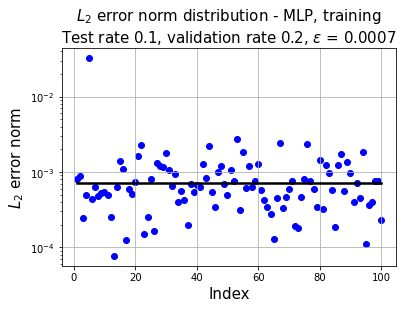

In [69]:
plt.plot(np.linspace(1,x_train.shape[0],x_train.shape[0]),
         l2_error_train*np.ones(x_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_train.shape[0], x_train.shape[0]), l2_error_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - MLP, training\nTest rate {0}, validation rate {1}, $\epsilon$ = {2:0.4f}'.format(test_rate,
                                                                                                                            val_rate,
                                                                                                                            l2_error_train), fontsize=15)
plt.grid()
saveName = "trainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

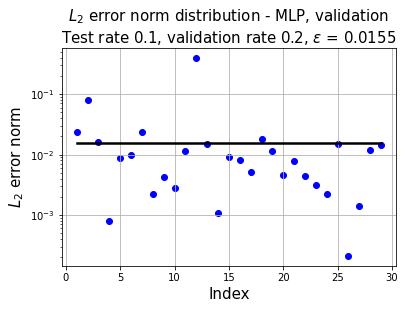

In [70]:
plt.plot(np.linspace(1,x_val.shape[0],x_val.shape[0]),
         l2_error_val*np.ones(x_val.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_val.shape[0], x_val.shape[0]), l2_error_val_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - MLP, validation\nTest rate {0}, validation rate {1}, $\epsilon$ = {2:0.4f}'.format(test_rate,
                                                                                                                              val_rate,
                                                                                                                              l2_error_val), fontsize=15)
plt.grid()
saveName = "validationErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

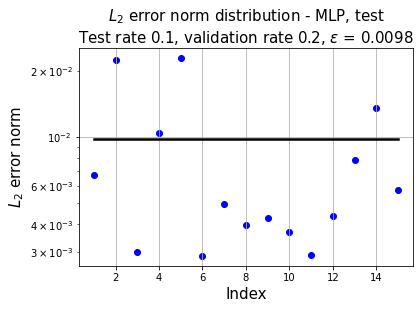

In [71]:
plt.plot(np.linspace(1,x_test.shape[0],x_test.shape[0]),
         l2_error_test*np.ones(x_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_test.shape[0], x_test.shape[0]), l2_error_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - MLP, test\nTest rate {0}, validation rate {1}, $\epsilon$ = {2:0.4f}'.format(test_rate,
                                                                                                                        val_rate,
                                                                                                                        l2_error_test), fontsize=15)
plt.grid()
saveName = "testErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

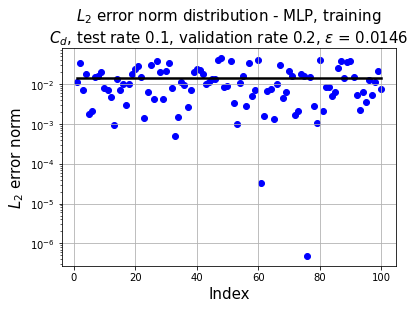

In [72]:
plt.plot(np.linspace(1,x_train.shape[0],x_train.shape[0]),
         l2_error_Cd_train*np.ones(x_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_train.shape[0], x_train.shape[0]), l2_error_train_Cd_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - MLP, training\n$C_d$, test rate {0}, validation rate {1}, $\epsilon$ = {2:0.4f}'.format(test_rate,
                                                                                                                                   val_rate,
                                                                                                                                   l2_error_Cd_train), fontsize=15)
plt.grid()
saveName = "CdtrainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

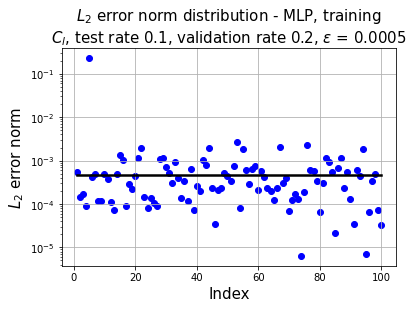

In [73]:
plt.plot(np.linspace(1,x_train.shape[0],x_train.shape[0]),
         l2_error_Cl_train*np.ones(x_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_train.shape[0], x_train.shape[0]), l2_error_train_Cl_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - MLP, training\n$C_l$, test rate {0}, validation rate {1}, $\epsilon$ = {2:0.4f}'.format(test_rate, 
                                                                                                                                   val_rate,
                                                                                                                                   l2_error_Cl_train), fontsize=15)
plt.grid()
saveName = "CltrainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

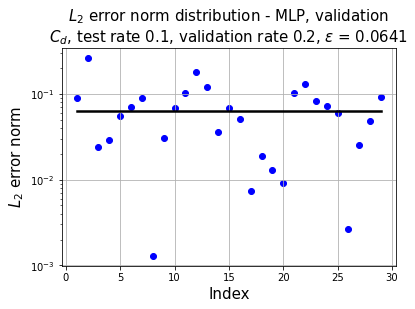

In [74]:
plt.plot(np.linspace(1,x_val.shape[0],x_val.shape[0]),
         l2_error_Cd_val*np.ones(x_val.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_val.shape[0], x_val.shape[0]), l2_error_val_Cd_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - MLP, validation\n$C_d$, test rate {0}, validation rate {1}, $\epsilon$ = {2:0.4f}'.format(test_rate,
                                                                                                                                     val_rate,
                                                                                                                                     l2_error_Cd_val), fontsize=15)
plt.grid()
saveName = "CdvalidationErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

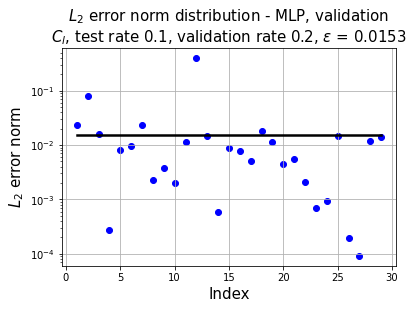

In [75]:
plt.plot(np.linspace(1,x_val.shape[0],x_val.shape[0]),
         l2_error_Cl_val*np.ones(x_val.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_val.shape[0], x_val.shape[0]), l2_error_val_Cl_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - MLP, validation\n$C_l$, test rate {0}, validation rate {1}, $\epsilon$ = {2:0.4f}'.format(test_rate, 
                                                                                                                                   val_rate,
                                                                                                                                   l2_error_Cl_val), fontsize=15)
plt.grid()
saveName = "ClvalidationErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

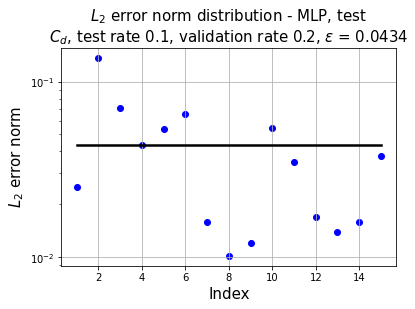

In [76]:
plt.plot(np.linspace(1,x_test.shape[0],x_test.shape[0]),
         l2_error_Cd_test*np.ones(x_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_test.shape[0], x_test.shape[0]), l2_error_test_Cd_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - MLP, test\n$C_d$, test rate {0}, validation rate {1}, $\epsilon$ = {2:0.4f}'.format(test_rate,
                                                                                                                               val_rate,
                                                                                                                               l2_error_Cd_test), fontsize=15)
plt.grid()
saveName = "CdtestErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

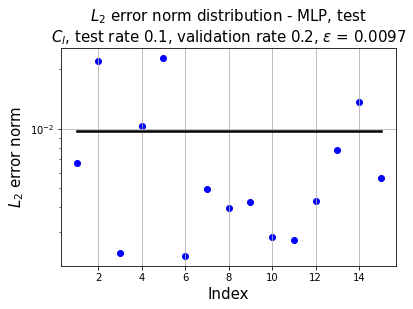

In [77]:
plt.plot(np.linspace(1,x_test.shape[0],x_test.shape[0]),
         l2_error_Cl_test*np.ones(x_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_test.shape[0], x_test.shape[0]), l2_error_test_Cl_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - MLP, test\n$C_l$, test rate {0}, validation rate {1}, $\epsilon$ = {2:0.4f}'.format(test_rate,
                                                                                                                               val_rate,
                                                                                                                               l2_error_Cl_test), fontsize=15)
plt.grid()
saveName = "CltestErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [78]:
aa = aa*np.max(alpha)

In [79]:
index_train = np.unique(np.where(np.isin(y, y_train)))
index_val = np.unique(np.where(np.isin(y, y_val)))
index_test = np.unique(np.where(np.isin(y, y_test)))

In [80]:
iTrain=[]
iVal=[]
iTest=[]
for i, index in enumerate(index_train):
    iTrain.append(y[index])
for i, index in enumerate(index_val):
    iVal.append(y[index])
for j, index in enumerate(index_test):
    iTest.append(y[index])

In [81]:
iTrain = np.array(iTrain)
iVal = np.array(iVal)
iTest = np.array(iTest)

In [82]:
predicted = model.predict(x)

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 15ms/step
L2 error of Cd: 0.0402, L2 error of Cl: 0.0060
(3, 2)


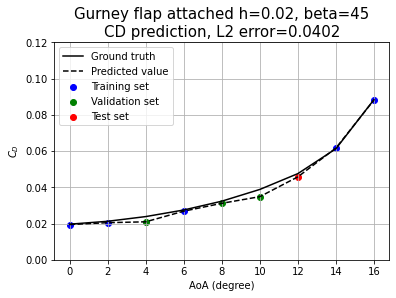

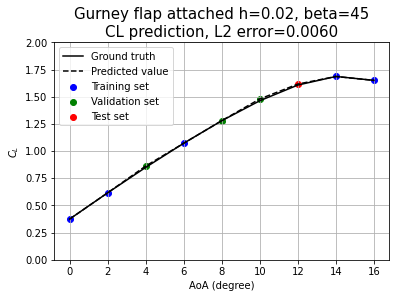

1/1 [==============================] - 0s 15ms/step
L2 error of Cd: 0.0477, L2 error of Cl: 0.0107
(3, 2)


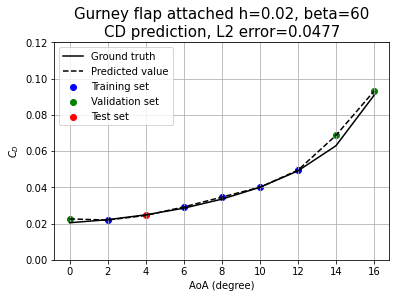

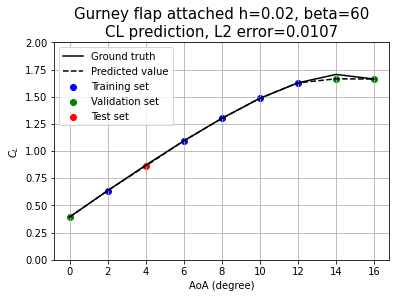

1/1 [==============================] - 0s 14ms/step
L2 error of Cd: 0.0450, L2 error of Cl: 0.0083
(2, 2)


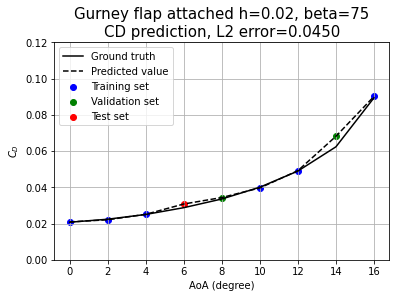

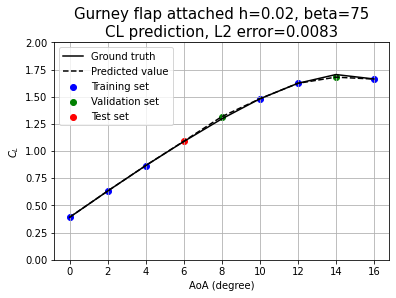

1/1 [==============================] - 0s 15ms/step
L2 error of Cd: 0.0430, L2 error of Cl: 0.0056
(3, 2)


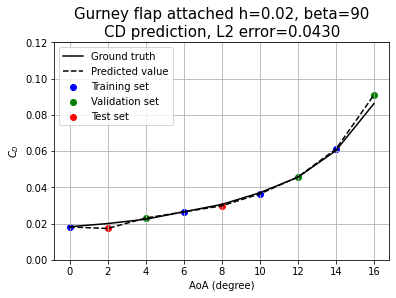

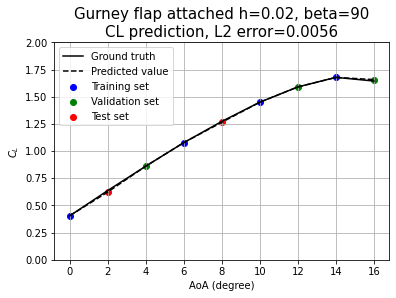

1/1 [==============================] - 0s 14ms/step
L2 error of Cd: 0.0291, L2 error of Cl: 0.0061
(2, 2)


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [91]:
h = [0, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.02, 0.02, 0.02, 0.02, 0.03, 0.03, 0.03, 0.03, 0.03]
beta = [0, 30, 45, 60, 75, 90, 30, 45, 60, 75, 90, 30, 45, 60, 75, 90]
for i in range(7, 16):
    iTrain = []
    iVal=[]
    iTest = []
    
    predictedValue = model.predict(x[n_alpha*i:n_alpha*(i+1),:])
    y_corres = y[n_alpha*i:n_alpha*(i+1),:]
    
    l2_error_Cd = np.sqrt(np.sum((predictedValue[:,0] - y_corres[:,0])**2) / np.sum(y_corres[:,0]**2))
    l2_error_Cl = np.sqrt(np.sum((predictedValue[:,1] - y_corres[:,1])**2) / np.sum(y_corres[:,1]**2))
    
    if i==0:
        print('NACA0018 airfoil without Gurney flap\nL2 error of Cd: {0:0.4f}, L2 error of Cl: {1:0.4f}'.format(l2_error_Cd, l2_error_Cl))
    else:
        print('L2 error of Cd: {0:0.4f}, L2 error of Cl: {1:0.4f}'.format(l2_error_Cd, l2_error_Cl))
    
    cl = predicted[n_alpha*i:n_alpha*(i+1),1]
    cd = predicted[n_alpha*i:n_alpha*(i+1),0]
    
    CL = y[n_alpha*i:n_alpha*(i+1),1]
    CD = y[n_alpha*i:n_alpha*(i+1),0]
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*n_alpha) & ((index_train>=i*n_alpha)))]):
        iTrain.append(predicted[index])

    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*n_alpha) & ((index_val>=i*n_alpha)))]):
        iVal.append(predicted[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*n_alpha) & (index_test>=i*n_alpha))]):
        iTest.append(predicted[index])
        
    iTrain = np.array(iTrain)
    iVal = np.array(iVal)
    iTest = np.array(iTest)
    print(iVal.shape)
    alpha_train = []
    alpha_val = []
    alpha_test = []
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*n_alpha) & ((index_train>=i*n_alpha)))]):
        alpha_train.append(aa[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*n_alpha) & ((index_val>=i*n_alpha)))]):
        alpha_val.append(aa[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*n_alpha) & ((index_test>=i*n_alpha)))]):
        alpha_test.append(aa[index])
        
    aTrain = np.array(alpha_train)[:,0]
    aVal = np.array(alpha_val)[:,0]
    aTest = np.array(alpha_test)[:,0]
    
    if i==0:
        plt.plot(alpha, CD, 'k-', label='Ground truth')
        plt.plot(alpha, cd, 'k--', label='Predicted value')
        plt.scatter(aTrain, iTrain[:,0], color='b', label='Training set')
        plt.scatter(aVal, iVal[:,0], color='g', label='Validation set')
        plt.scatter(aTest, iTest[:,0], color='r', label='Test set')
        plt.xlabel('AoA (degree)')
        plt.ylabel('$C_D$')
        plt.title('Gurney flap not attached (NACA0018)\n$C_D$ prediction, L2 error=%.4f' % l2_error_Cd, fontsize=15)
        plt.legend(loc='upper left')
        plt.ylim([0, 0.12])
        plt.grid()
        savename1 = "CdComparison_NACA0018.jpg"
        plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
        plt.show()

        plt.plot(alpha, CL, 'k-', label='Ground truth')
        plt.plot(alpha, cl, 'k--', label='Predicted value')
        plt.scatter(aTrain, iTrain[:,1], color='b', label='Training set')
        plt.scatter(aVal, iVal[:,1], color='g', label='Validation set')
        plt.scatter(aTest, iTest[:,1], color='r', label='Test set')
        plt.xlabel('AoA (degree)')
        plt.ylabel('$C_L$')
        plt.title('Gurney flap not attached (NACA0018)\n$C_L$ prediction, L2 error=%.4f' % l2_error_Cl, fontsize=15)
        plt.legend(loc='upper left')
        plt.ylim([0, 2])
        plt.grid()
        savename2 = "ClComparison_NACA0018.jpg"
        plt.savefig(savename2, dpi=300, bbox_inches='tight', pad_inches=0.3)
        plt.show()
    
    else:
        plt.plot(alpha, CD, 'k-', label='Ground truth')
        plt.plot(alpha, cd, 'k--', label='Predicted value')
        plt.scatter(aTrain, iTrain[:,0], color='b', label='Training set')
        plt.scatter(aVal, iVal[:,0], color='g', label='Validation set')
        plt.scatter(aTest, iTest[:,0], color='r', label='Test set')
        plt.xlabel('AoA (degree)')
        plt.ylabel('$C_D$')
        plt.title('Gurney flap attached h=%.2f, beta=%d\nCD prediction, L2 error=%.4f'%(h[i], beta[i],l2_error_Cd), fontsize=15)
        plt.legend(loc='upper left')
        plt.ylim([0, 0.12])
        plt.grid()
        savename1 = "CdComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
        plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
        plt.show()

        plt.plot(alpha, CL, 'k-', label='Ground truth')
        plt.plot(alpha, cl, 'k--', label='Predicted value')
        plt.scatter(aTrain, iTrain[:,1], color='b', label='Training set')
        plt.scatter(aVal, iVal[:,1], color='g', label='Validation set')
        plt.scatter(aTest, iTest[:,1], color='r', label='Test set')
        plt.xlabel('AoA (degree)')
        plt.ylabel('$C_L$')
        plt.title('Gurney flap attached h=%.2f, beta=%d\nCL prediction, L2 error=%.4f'%(h[i], beta[i], l2_error_Cl), fontsize=15)
        plt.legend(loc='upper left')
        plt.ylim([0, 2])
        plt.grid()
        savename2 = "ClComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
        plt.savefig(savename2, dpi=300, bbox_inches='tight', pad_inches=0.3)
        plt.show()